## Analysis of misclassified examples

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from scipy import stats
from scipy.stats import hypergeom
import pubchempy as pcp
from scipy.stats import ranksums

Read the misclassifications

In [2]:
misclass_DTI_Bridge = open('misclass_DTI_bridge.pkl', 'rb')
miscl_res_DTI_bridge = pkl.load(misclass_DTI_Bridge)
misclass_DTI_Bridge.close()

misclass_pEmb = open('misclass_p_Embedding.pkl', 'rb')
miscl_res_pEmb = pkl.load(misclass_pEmb)
misclass_pEmb.close()

Separate proteins and drugs from misclassified examples

In [3]:
proteins_DTI_Bridge = []
drugs_DTI_bridge = []
proteins_pEmb = []
drugs_pEmb = []

for prot, drug in miscl_res_DTI_bridge[0]:
    if prot not in proteins_DTI_Bridge:
        proteins_DTI_Bridge.append(prot)
    if drug not in drugs_DTI_bridge:
        drugs_DTI_bridge.append(drug)
    
for prot, drug in miscl_res_pEmb[0]:
    if prot not in proteins_pEmb:
        proteins_pEmb.append(prot)
    if drug not in drugs_pEmb:
        drugs_pEmb.append(drug)

In [4]:
#Check number of misclassified training examples
print('Total misclassifications original method:', len(miscl_res_DTI_bridge[0]))
print('Total misclassifications modified architecture:', len(miscl_res_pEmb[0]))

Total misclassifications original method: 579
Total misclassifications modified architecture: 524


In [5]:
#Check number of misclassified proteins (unique) in both of them
print('Misclassified proteins DTI:', len(proteins_DTI_Bridge))
print('Misclassified drugs DTI:', len(drugs_DTI_bridge))

print('Misclassified proteins pEmb:', len(proteins_pEmb))
print('Misclassified drugs pEmb:', len(drugs_pEmb))


Misclassified proteins DTI: 189
Misclassified drugs DTI: 574
Misclassified proteins pEmb: 182
Misclassified drugs pEmb: 520


In [6]:
#Isolate the lengths
protein_length_DTI_Bridge = [len(i) for i in  proteins_DTI_Bridge]
protein_length_pEmb = [len(i) for i in  proteins_pEmb]

Histogram of frequencies of protein lengths

In [7]:
#Binning and transformation to relative frequencies
abs_freq_DTI, bins_DTI = np.histogram(protein_length_DTI_Bridge, 100)
rel_freq_DTI = abs_freq_DTI/len(protein_length_DTI_Bridge)

abs_freq_pEmb, bins_pEmb = np.histogram(protein_length_pEmb, 100)
rel_freq_pEmb = abs_freq_pEmb/len(protein_length_pEmb)

In [8]:
#Probabilities so that histogram y-axis is fractional
weights_DTI = np.ones_like(protein_length_DTI_Bridge)/len(protein_length_DTI_Bridge)
weights_pEmb = np.ones_like(protein_length_pEmb)/len(protein_length_pEmb)

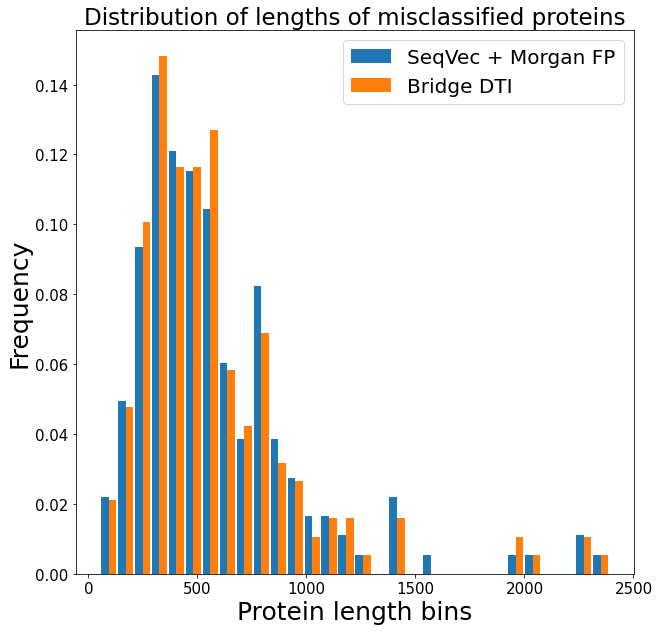

In [9]:
#plot histograms of lengths
plt.figure(figsize = (10,10))
plt.hist([protein_length_pEmb,protein_length_DTI_Bridge], weights = [weights_pEmb, weights_DTI],  bins = 30, rwidth = 0.9)
plt.title('Distribution of lengths of misclassified proteins', fontsize = 23)
plt.legend(('SeqVec + Morgan FP', 'Bridge DTI'), prop = {'size':20})
plt.ylabel('Frequency', fontsize = 25)
plt.xlabel('Protein length bins', fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

**Statistical test**

In [10]:
#First Kolmogorov-Smirnov
stats.kstest(protein_length_pEmb, protein_length_DTI_Bridge)

KstestResult(statistic=0.0352055352055352, pvalue=0.9994749480011365)

In [14]:
#Check number of shared misclassifications
shared = 0
for prot in proteins_DTI_Bridge:
    if prot in proteins_pEmb:
        shared += 1
print(shared)

154


**Overview of proteins**

In [15]:
#Look at the mean 
print('Mean protein length DTI: ', np.mean(protein_length_DTI_Bridge))
print('Mean protein length pEmb: ', np.mean(protein_length_pEmb))

print()
print('Max protein length DTI: ', np.max(protein_length_DTI_Bridge))
print('Max protein length pEmb: ', np.max(protein_length_pEmb))

print()
print('Min protein length DTI: ', np.min(protein_length_DTI_Bridge))
print('Min protein length pEmb: ', np.min(protein_length_pEmb))

Mean protein length DTI:  577.3544973544973
Mean protein length pEmb:  588.1483516483516

Max protein length DTI:  2388
Max protein length pEmb:  2388

Min protein length DTI:  54
Min protein length pEmb:  54


In [18]:
#How many positive examples. 

Y_DTI = miscl_res_DTI_bridge[1]
Y_pEmb = miscl_res_pEmb[1]

print('DTI FPs:', np.unique(Y_DTI, return_counts = True)[1][0])
print('DTI FNs:', np.unique(Y_DTI, return_counts = True)[1][1])

print('SeqVec FPs:', np.unique(Y_pEmb, return_counts = True)[1][0])
print('SeqVec FNs:', np.unique(Y_pEmb, return_counts = True)[1][1])

DTI FPs: 345
DTI FNs: 234
SeqVec FPs: 171
SeqVec FNs: 353


In [19]:
#Check how many similar misclassifictaions 
count = 0 
for ex in miscl_res_DTI_bridge[0]:
    if ex in miscl_res_pEmb[0]:
        count += 1
print('Common misclassified: ', count)

Common misclassified:  349


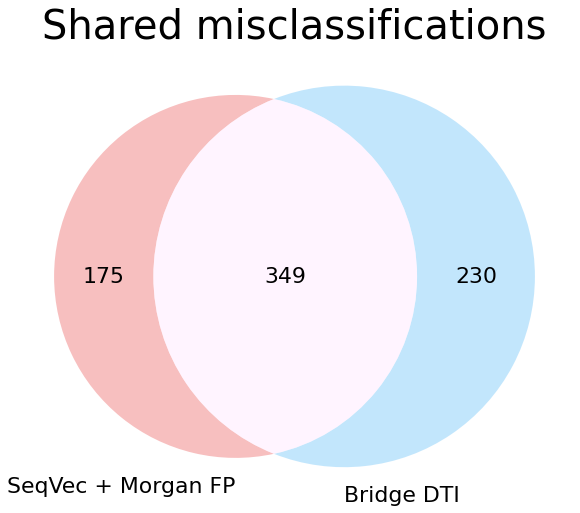

In [21]:
#Draw Venn diagram of results
plt.figure(figsize=(10,10))
venn_prot = venn2(subsets = (len(miscl_res_pEmb[0])-count, len(miscl_res_DTI_bridge[0])-count,count ), set_labels = ('SeqVec + Morgan FP', 'Bridge DTI'), 
      set_colors=('lightcoral', 'lightskyblue'), alpha = 0.5)


for text in venn_prot.set_labels:
    text.set_fontsize(22);
for text in venn_prot.subset_labels:
    text.set_fontsize(22)

plt.title('Shared misclassifications', fontsize = 40)
plt.show()

Check now which are the most misclassified proteins and drugs

In [39]:
miscl_protein_freqs = {}
miscl_drug_freq = {}

for prot, drug in miscl_res_pEmb[0]:
    if prot not in miscl_protein_freqs:
        miscl_protein_freqs[prot] = 1
    else:
        miscl_protein_freqs[prot] += 1
    if drug not in miscl_drug_freq:
        miscl_drug_freq[drug] = 1
    else:
        miscl_drug_freq[drug] += 1

sorted_freqs_miscl = sorted(miscl_protein_freqs.items(), key = lambda x: x[1], reverse = True)
sorted_freqs_miscl

[('MASSGMADSANHLPFFFGNITREEAEDYLVQGGMSDGLYLLRQSRNYLGGFALSVAHGRKAHHYTIERELNGTYAIAGGRTHASPADLCHYHSQESDGLVCLLKKPFNRPQGVQPKTGPFEDLKENLIREYVKQTWNLQGQALEQAIISQKPQLEKLIATTAHEKMPWFHGKISREESEQIVLIGSKTNGKFLIRARDNNGSYALCLLHEGKVLHYRIDKDKTGKLSIPEGKKFDTLWQLVEHYSYKADGLLRVLTVPCQKIGTQGNVNFGGRPQLPGSHPASSPAQGNRQESTVSFNPYEPELAPWAADKGPQREALPMDTEVYESPYADPEEIRPKEVYLDRKLLTLEDKELGSGNFGTVKKGYYQMKKVVKTVAVKILKNEANDPALKDELLAEANVMQQLDNPYIVRMIGICEAESWMLVMEMAELGPLNKYLQQNRHVKDKNIIELVHQVSMGMKYLEESNFVHRDLAARNVLLVTQHYAKISDFGLSKALRADENYYKAQTHGKWPVKWYAPECINYYKFSSKSDVWSFGVLMWEAFSYGQKPYRGMKGSEVTAMLEKGERMGCPAGCPREMYDLMNLCWTYDVENRPGFAAVELRLRNYYYDVVN',
  59),
 ('MRQSLLFLTSVVPFVLAPRPPDDPGFGPHQRLEKLDSLLSDYDILSLSNIQQHSVRKRDLQTSTHVETLLTFSALKRHFKLYLTSSTERFSQNFKVVVVDGKNESEYTVKWQDFFTGHVVGEPDSRVLAHIRDDDVIIRINTDGAEYNIEPLWRFVNDTKDKRMLVYKSEDIKNVSRLQSPKVCGYLKVDNEELLPKGLVDREPPEELVHRVKRRADPDPMKNTCKLLVVADHRFYRYMGRGEESTTTNYLIELIDRVDDIYRNTSWDNAGFKGYGIQIEQIRILKSPQEVKPGEKHYNMAKSYPNEEKDAWDVKMLLEQFSFDIAEEASKVCLAHLFTYQDFDMGTLGLAYVGSPRANSHGGVCPKAYYSP

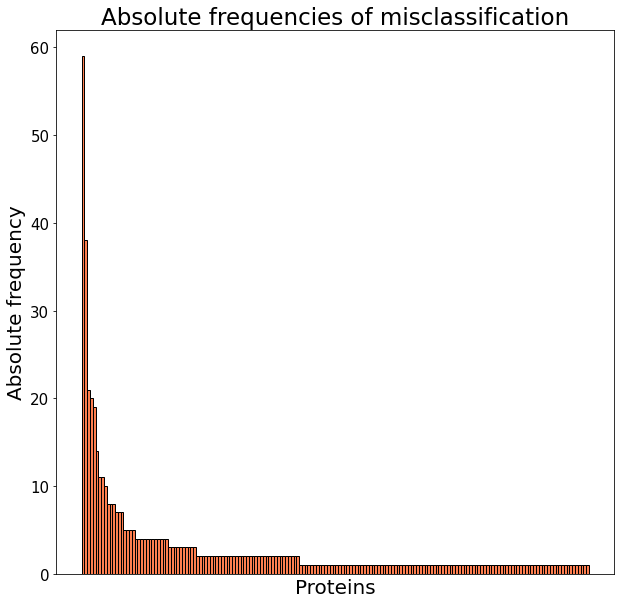

In [22]:
#plot histograms of lengths
plt.figure(figsize = (10,10))
plt.bar(np.arange(len(sorted_freqs_miscl)),sorted(miscl_protein_freqs.values(), reverse= True), color ='coral', width=1,
       edgecolor = 'black')
plt.title('Absolute frequencies of misclassification', fontsize = 23)
plt.ylabel('Absolute frequency', fontsize = 20)
plt.xlabel('Proteins', fontsize = 20)
plt.xticks([], [])
plt.yticks(fontsize = 15)
plt.show()

Blast the first 5 proteins:

* tyrosine-protein kinase SYK isoform Syk(S)
            This gene encodes a member of the family of non-receptor
            type Tyr protein kinases. This protein is widely expressed in
            hematopoietic cells and is involved in coupling activated
            immunoreceptors to downstream signaling events that mediate diverse
            cellular responses, including proliferation, differentiation, and
            phagocytosis. It is thought to be a modulator of epithelial cell
            growth and a potential tumour suppressor in human breast
            carcinomas. Alternatively spliced transcript variants encoding
            different isoforms have been found for this gene.

* disintegrin and metalloproteinase domain-containing protein 17 isoform 1 preproprotein: Elevated expression of
            this gene has been observed in specific cell types derived from
            psoriasis, rheumatoid arthritis, multiple sclerosis and Crohn's
            disease patients, suggesting that the encoded protein may play a
            role in autoimmune disease. Additionally, this protease may play a
            role in viral infection through its cleavage of ACE2, the cellular
            receptor for SARS-CoV and SARS-CoV-2.
* lipoprotein lipase H 
            LPL is the rate-limiting enzyme for the hydrolysis of the triglyceride (TG) 
            core of circulating TG-rich lipoproteins, chylomicrons, and very low-density 
            lipoproteins (VLDL). Mice with overexpression of LPL in skeletal muscle accumulate 
            TG in muscle, develop insulin resistance, are protected from excessive weight gain, 
            and increase their metabolic rate in the cold.


In [22]:
#Inspect the problem with tyrosine-protein kinase SYK isoform Syk(S)
d_SYK = {'1':0, '0':0}
for i in range(len(miscl_res_pEmb[0])):
    if miscl_res_pEmb[0][i][0] == 'MASSGMADSANHLPFFFGNITREEAEDYLVQGGMSDGLYLLRQSRNYLGGFALSVAHGRKAHHYTIERELNGTYAIAGGRTHASPADLCHYHSQESDGLVCLLKKPFNRPQGVQPKTGPFEDLKENLIREYVKQTWNLQGQALEQAIISQKPQLEKLIATTAHEKMPWFHGKISREESEQIVLIGSKTNGKFLIRARDNNGSYALCLLHEGKVLHYRIDKDKTGKLSIPEGKKFDTLWQLVEHYSYKADGLLRVLTVPCQKIGTQGNVNFGGRPQLPGSHPASSPAQGNRQESTVSFNPYEPELAPWAADKGPQREALPMDTEVYESPYADPEEIRPKEVYLDRKLLTLEDKELGSGNFGTVKKGYYQMKKVVKTVAVKILKNEANDPALKDELLAEANVMQQLDNPYIVRMIGICEAESWMLVMEMAELGPLNKYLQQNRHVKDKNIIELVHQVSMGMKYLEESNFVHRDLAARNVLLVTQHYAKISDFGLSKALRADENYYKAQTHGKWPVKWYAPECINYYKFSSKSDVWSFGVLMWEAFSYGQKPYRGMKGSEVTAMLEKGERMGCPAGCPREMYDLMNLCWTYDVENRPGFAAVELRLRNYYYDVVN':
        if miscl_res_pEmb[1][i] == 1:
            d_SYK['1'] += 1
        else:
            d_SYK['0'] += 1

print(d_SYK.items())

dict_items([('1', 40), ('0', 19)])


Do the same with the second and third most frequent proteins.

In [23]:
d_disint = {'1':0, '0':0}
for i in range(len(miscl_res_pEmb[0])):
    if miscl_res_pEmb[0][i][0] == 'MRQSLLFLTSVVPFVLAPRPPDDPGFGPHQRLEKLDSLLSDYDILSLSNIQQHSVRKRDLQTSTHVETLLTFSALKRHFKLYLTSSTERFSQNFKVVVVDGKNESEYTVKWQDFFTGHVVGEPDSRVLAHIRDDDVIIRINTDGAEYNIEPLWRFVNDTKDKRMLVYKSEDIKNVSRLQSPKVCGYLKVDNEELLPKGLVDREPPEELVHRVKRRADPDPMKNTCKLLVVADHRFYRYMGRGEESTTTNYLIELIDRVDDIYRNTSWDNAGFKGYGIQIEQIRILKSPQEVKPGEKHYNMAKSYPNEEKDAWDVKMLLEQFSFDIAEEASKVCLAHLFTYQDFDMGTLGLAYVGSPRANSHGGVCPKAYYSPVGKKNIYLNSGLTSTKNYGKTILTKEADLVTTHELGHNFGAEHDPDGLAECAPNEDQGGKYVMYPIAVSGDHENNKMFSNCSKQSIYKTIESKAQECFQERSNKVCGNSRVDEGEECDPGIMYLNNDTCCNSDCTLKEGVQCSDRNSPCCKNCQFETAQKKCQEAINATCKGVSYCTGNSSECPPPGNAEDDTVCLDLGKCKDGKCIPFCEREQQLESCACNETDNSCKVCCRDLSGRCVPYVDAEQKNLFLRKGKPCTVGFCDMNGKCEKRVQDVIERFWDFIDQLSINTFGKFLADNIVGSVLVFSLIFWIPFSILVHCV':
        if miscl_res_pEmb[1][i] == 1:
            d_disint['1'] += 1
        else:
            d_disint['0'] += 1

print(d_disint.items())

dict_items([('1', 25), ('0', 13)])


In [24]:
d_lipo = {'1':0, '0':0}
for i in range(len(miscl_res_pEmb[0])):
    if miscl_res_pEmb[0][i][0] == 'MSNSVPLLCFWSLCYCFAAGSPVPFGPEGRLEDKLHKPKATQTEVKPSVRFNLRTSKDPEHEGCYLSVGHSQPLEDCSFNMTAKTFFIIHGWTMSGIFENWLHKLVSALHTREKDANVVVVDWLPLAHQLYTDAVNNTRVVGHSIARMLDWLQEKDDFSLGNVHLIGYSLGAHVAGYAGNFVKGTVGRITGLDPAGPMFEGADIHKRLSPDDADFVDVLHTYTRSFGLSIGIQMPVGHIDIYPNGGDFQPGCGLNDVLGSIAYGTITEVVKCEHERAVHLFVDSLVNQDKPSFAFQCTDSNRFKKGICLSCRKNRCNSIGYNAKKMRNKRNSKMYLKTRAGMPFRGNLQSLECP':
        if miscl_res_pEmb[1][i] == 1:
            d_lipo['1'] += 1
        else:
            d_lipo['0'] += 1

print(d_lipo.items())

dict_items([('1', 7), ('0', 14)])


Check for the misclassifications from 1 to 0 if there are some cumulative ones

**See the balance of miclassified proteins in the whole test set**

In [32]:
#Get the whole testset
test_set_file = open('test.pkl', 'rb')
info_set = pkl.load(test_set_file)
test_set_file.close()

In [33]:
test_set_data = info_set[0]
test_set_data

[('MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCSDPSPGIVAFPRLEPNSVDPENITEIFIANQKRLEIINEDDVEAYVGLRNLTIVDSGLKFVAHKAFLKNSNLQHINFTRNKLTSLSRKHFRHLDLSELILVGNPFTCSCDIMWIKTLQEAKSSPDTQDLYCLNESSKNIPLANLQIPNCGLPSANLAAPNLTVEEGKSITLSCSVAGDPVPNMYWDVGNLVSKHMNETSHTQGSLRITNISSDDSGKQISCVAENLVGEDQDSVNLTVHFAPTITFLESPTSDHHWCIPFTVKGNPKPALQWFYNGAILNESKYICTKIHVTNHTEYHGCLQLDNPTHMNNGDYTLIAKNEYGKDEKQISAHFMGWPGIDDGANPNYPDVIYEDYGTAANDIGDTTNRSNEIPSTDVTDKTGREHLSVYAVVVIASVVGFCLLVMLFLLKLARHSKFGMKGFVLFHKIPLDG',
  'COC1=NC=C(C=C1)COC2=C(C=C(C=C2)CN3C=NC4=C3N=CC(=C4)C5=NN=C(O5)C6CCNCC6)OC'),
 ('MRGARGAWDFLCVLLLLLRVQTGSSQPSVSPGEPSPPSIHPGKSDLIVRVGDEIRLLCTDPGFVKWTFEILDETNENKQNEWITEKAEATNTGKYTCTNKHGLSNSIYVFVRDPAKLFLVDRSLYGKEDNDTLVRCPLTDPEVTNYSLKGCQGKPLPKDLRFIPDPKAGIMIKSVKRAYHRLCLHCSVDQEGKSVLSEKFILKVRPAFKAVPVVSVSKASYLLREGEEFTVTCTIKDVSSSVYSTWKRENSQTKLQEKYNSWHHGDFNYERQATLTISSARVNDSGVFMCYANNTFGSANVTTTLEVVDKGFINIFPMINTTVFVNDGENVDLIVEYEAFPKPEHQQWIYMNRTFTDKWEDYPKSENESNIRYVSELHLTRLKGTEGGTYTFLVSNSDVNAAIAFNVYVNTKPEILTYDRLVNGMLQCVAAGFP

In [35]:
#Get the frequency of proteins in the test set
freqs_prot_test_set = {}

for ex in test_set_data:
    if ex[0] in freqs_prot_test_set:
        freqs_prot_test_set[ex[0]] += 1
    else:
        freqs_prot_test_set[ex[0]] = 1

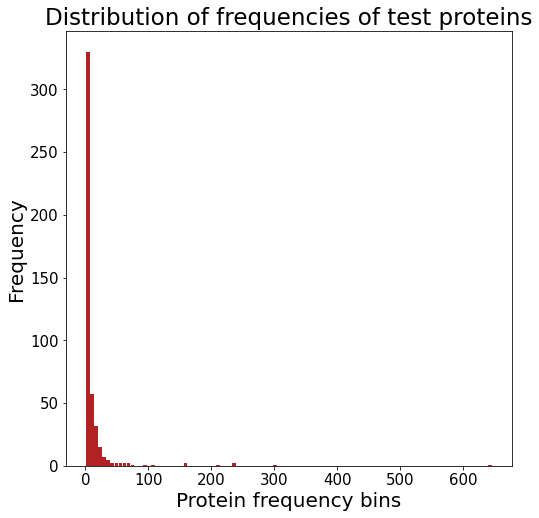

In [36]:
#plot histograms of frequencies
plt.figure(figsize = (8,8))
plt.hist(list(freqs_prot_test_set.values()), bins = 100, rwidth = 0.9, color ='firebrick')
plt.title('Distribution of frequencies of test proteins', fontsize = 23)
plt.ylabel('Frequency', fontsize = 20)
plt.xlabel('Protein frequency bins', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [37]:
#Inspect the values of the unique frequencies present.
np.unique(list(freqs_prot_test_set.values()))

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        28,  29,  31,  32,  33,  34,  35,  37,  39,  40,  42,  48,  54,
        55,  64,  66,  68,  73,  94, 110, 156, 157, 210, 238, 239, 304,
       646])

In [40]:
#Run the hyper-geometric distribution tests: Check if the most often misclassified proteins are ubiquitous in test examples
M = len(test_set_data)
for miscl_protein in miscl_protein_freqs:
    #The number of times a protein is found in the test set
    n = freqs_prot_test_set[miscl_protein]
    #The number of misclassifications
    N = len(miscl_res_pEmb[0])
    rv = hypergeom(M, n, N)
    x = miscl_protein_freqs[miscl_protein]
    p = 1-rv.cdf(x)
    print(p, n, x)

0.03332270517149638 8 2
0.6407566486070201 34 2
0.1504031658694862 64 8
0.7025979938413918 25 1
0.020604572359792517 37 7
0.3040650333857251 48 5
0.6385794272973352 68 5
0.13655814447132697 54 7
0.0253916166822854 3 1
0.172448915181875 8 1
0.6331971016877695 22 1
0.2556126177702289 73 8
0.20842659172322753 9 1
0.1417832916131656 14 2
0.031884384870882077 26 5
0.1047290238954679 6 1
0.7768716543258257 42 2
0.061895580149994855 10 2
0.6201984780746115 33 2
0.172448915181875 8 1
0.04760018758379703 4 1
0.4908067335967492 17 1
0.00903491285683089 2 1
0.037166245858118785 64 10
0.061895580149994855 10 2
0.06102903522589298 23 4
0.6605207438371903 35 2
0.0 1 1
0.006914020943304178 9 3
0.3185722823997277 12 1
0.09852603489575196 12 2
0.11942562390100697 13 2
0.0012843464475149613 10 4
0.24505934462194545 10 1
0.18320817663774003 32 4
0.01799144790293883 17 4
0.0 1 1
0.16670691958350736 31 4
0.11942562390100697 13 2
0.07440326418044085 5 1
0.02156513627102674 12 3
0.0008565609351609549 3 2
0.0

**Print for ClustalOmega**

In [41]:
#Get the misclassified proteins in an appropriate format for ClustalOmega
count = 1
for prot in miscl_protein_freqs:
    print(f'>protein{count}')
    print(prot)
    print()
    count+=1

>protein1
METTQYMNEGELRVLADTYDSVYLHPNSYSCACLASGSVLRLVDAVLGAEIRNGMAIIRPPGHHAQHSLMDGYCMFNHVAVAARYAQQKHRIRRVLIVDWDVHHGQGTQFTFDQDPSVLYFSIHRYEQGRFWPHLKASNWSTTGFGQGQGYTINVPWNQVGMRDADYIAAFLHVLLPVALEFQPQLVLVAAGFDALQGDPKGEMAATPAGFAQLTHLLMGLAGGKLILSLEGGYNLRALAEGVSASLHTLLGDPCPMLESPGAPCRSAQASVSCALEALEPFWEVLVRSTETVERDNMEEDNVEESEEEGPWEPPVLPILTWPVLQSRTGLVYDQNMMNHCNLWDSHHPEVPQRILRIMCRLEELGLAGRCLTLTPRPATEAELLTCHSAEYVGHLRATEKMKTRELHRESSNFDSIYICPSTFACAQLATGAACRLVEAVLSGEVLNGAAVVRPPGHHAEQDAACGFCFFNSVAVAARHAQTISGHALRILIVDWDVHHGNGTQHMFEDDPSVLYVSLHRYDHGTFFPMGDEGASSQIGRAAGTGFTVNVAWNGPRMGDADYLAAWHRLVLPIAYEFNPELVLVSAGFDAARGDPLGGCQVSPEGYAHLTHLLMGLASGRIILILEGGYNLTSISESMAACTRSLLGDPPPLLTLPRPPLSGALASITETIQVHRRYWRSLRVMKVEDREGPSSSKLVTKKAPQPAKPRLAERMTTREKKVLEAGMGKVTSASFGEESTPGQTNSETAVVALTQDQPSEAATGGATLAQTISEAAIGGAMLGQTTSEEAVGGATPDQTTSEETVGGAILDQTTSEDAVGGATLGQTTSEEAVGGATLAQTTSEAAMEGATLDQTTSEEAPGGTELIQTPLASSTDHQTPPTSPVQGTTPQISPSTLIGSLRTLELGSESQGASESQAPGEENLLGEAAGGQDMADSMLMQGSRGLTDQAIFYAVTPLPWCPHLVAVCPIPAAGLDVTQPCGDCGTIQEN

**Look at misclassified drugs**

In [42]:
miscl_drug_names = info_set[1]

In [43]:
len(miscl_drug_names)

524

In [44]:
#Create a dictionary with misclassified drugs and their frequency of misclassification 
miscl_drug_names_unique = {}

for drug in miscl_drug_names:
    if drug not in miscl_drug_names_unique:
        miscl_drug_names_unique[drug] = 1
    else:
        miscl_drug_names_unique[drug] += 1

In [45]:
#Check how many different misclassified drugs there are
len(miscl_drug_names_unique)

520

In [44]:
#Mine puchem for the information of the misclassified drugs
# drug_compounds = []
# for drug in miscl_drug_names_unique:
#     comp = pcp.Compound.from_cid(int(drug))
#     drug_compounds.append(comp)

In [47]:
#Dump the results in a pickle
# miscl_drug_properties_file = open('miscl_drug_properties_file', 'wb')
# pkl.dump( drug_compounds, miscl_drug_properties_file)
# miscl_drug_properties_file.close()

In [46]:
#Read the pickle with drug properties of misclassified drugs
miscl_drug_properties_file = open('miscl_drug_properties_file', 'rb')
drug_extended_names = pkl.load(miscl_drug_properties_file)
miscl_drug_properties_file.close()

In [47]:
#Setup the information arrays
complexities = []
charge = []
molecular_weight = []
logP = []
h_bond_donor_count = []
h_bond_acceptor_count = []
heavy_atom_count = []
atom_stereo_count = []

In [48]:
#Add results to the property arrays
for drug_compound in drug_extended_names:
    complexities.append(drug_compound.complexity)
    charge.append(drug_compound.charge)
    molecular_weight.append(drug_compound.molecular_weight)
    logP.append(drug_compound.xlogp)
    h_bond_donor_count.append(drug_compound.h_bond_donor_count)
    h_bond_acceptor_count.append(drug_compound.h_bond_acceptor_count)
    heavy_atom_count.append(drug_compound.heavy_atom_count)
    atom_stereo_count.append(drug_compound.atom_stereo_count)

**Drug complexity**

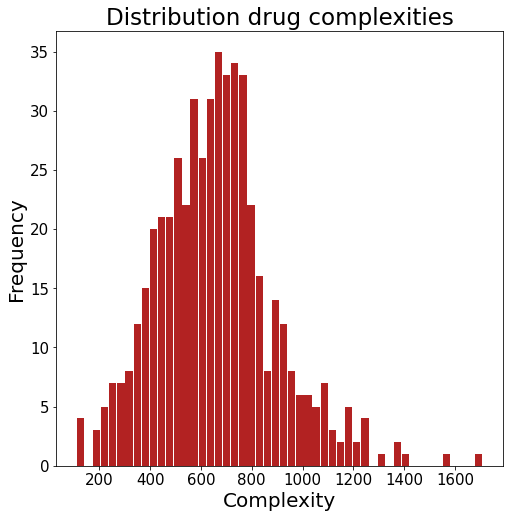

In [49]:
#plot histograms of lengths
plt.figure(figsize = (8,8))
plt.hist(complexities, bins = 50, rwidth = 0.9, color ='firebrick')
plt.title('Distribution drug complexities', fontsize = 23)
plt.ylabel('Frequency', fontsize = 20)
plt.xlabel('Complexity', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [50]:
print('Mean complexity among the misclassified drugs:', np.mean(complexities))
print('StdDev of complexity of the misclassified drugs:',np.std(complexities))

Mean complexity among the misclassified drugs: 658.6288461538461
StdDev of complexity of the misclassified drugs: 232.38743911882824


**Charge**

In [51]:
print('Mean complexity among the misclassified drugs:', np.mean(charge))
print('StdDev of complexity of the misclassified drugs:',np.std(charge))

Mean complexity among the misclassified drugs: 0.011538461538461539
StdDev of complexity of the misclassified drugs: 0.15147206667319396


**Molecular weight**

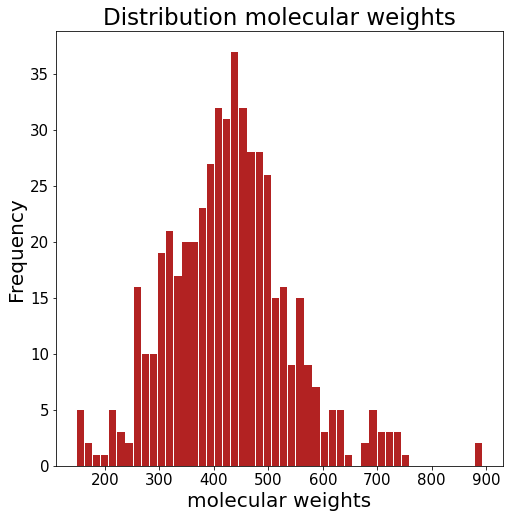

In [52]:
#plot histograms of lengths
plt.figure(figsize = (8,8))
plt.hist(molecular_weight, bins = 50, rwidth = 0.9, color ='firebrick')
plt.title('Distribution molecular weights', fontsize = 23)
plt.ylabel('Frequency', fontsize = 20)
plt.xlabel('molecular weights', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [53]:
print('Mean of MolWeight of the misclassified drugs:', np.mean(molecular_weight))
print('StdDev of MolWeight of the misclassified drugs:', np.std(molecular_weight))

Mean of MolWeight of the misclassified drugs: 428.6311538461539
StdDev of MolWeight of the misclassified drugs: 112.06020541438782


**logP**

In [54]:
logP = np.array(logP)
logP = logP[logP != None]

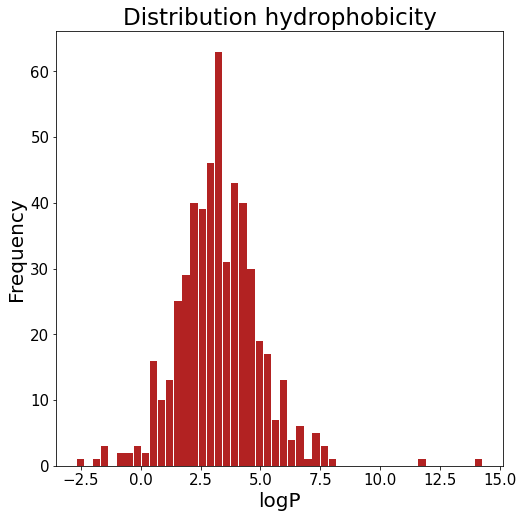

In [55]:
#plot histograms of lengths
plt.figure(figsize = (8,8))
plt.hist(logP, bins = 50, rwidth = 0.9, color ='firebrick')
plt.title('Distribution hydrophobicity', fontsize = 23)
plt.ylabel('Frequency', fontsize = 20)
plt.xlabel('logP', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [56]:
print('Mean of MolWeight of the misclassified drugs:', np.mean(logP))
print('StdDev of MolWeight of the misclassified drugs:', np.std(logP))

Mean of MolWeight of the misclassified drugs: 3.297098646034817
StdDev of MolWeight of the misclassified drugs: 1.722018994030226


Repeat process with all drugs in the test set to compare with the misclassified data.

In [57]:
#Get the frequency of proteins in the test set
drug_id_test_set = info_set[2]

In [58]:
len(drug_id_test_set)

5508

In [59]:
complexities_dataset = []
charge_dataset = []
molecular_weight_dataset = []
logP_dataset = []
h_bond_donor_count_dataset = []
h_bond_acceptor_count_dataset = []
heavy_atom_count_dataset = []
atom_stereo_count_dataset = []

In [60]:
# drug_compounds_test_set = []
# for drug in drug_id_test_set:
#     comp = pcp.Compound.from_cid(int(drug))
#     drug_compounds_test_set.append(comp)

In [65]:
#Read the pickle with drug properties of misclassified drugs
miscl_drug_properties_file = open('drug_properties_file_whole_ts', 'rb')
drug_compounds_test_set = pkl.load(miscl_drug_properties_file)
miscl_drug_properties_file.close()

In [66]:
for drug_compound in drug_compounds_test_set:
    complexities_dataset.append(drug_compound.complexity)
    charge_dataset.append(drug_compound.charge)
    molecular_weight_dataset.append(drug_compound.molecular_weight)
    logP_dataset.append(drug_compound.xlogp)
    h_bond_donor_count_dataset.append(drug_compound.h_bond_donor_count)
    h_bond_acceptor_count_dataset.append(drug_compound.h_bond_acceptor_count)
    heavy_atom_count_dataset.append(drug_compound.heavy_atom_count)
    atom_stereo_count_dataset.append(drug_compound.atom_stereo_count)

In [62]:
# miscl_drug_properties_file_whole_ts = open('drug_properties_file_whole_ts', 'wb')
# pkl.dump( drug_compounds_test_set, miscl_drug_properties_file_whole_ts)
# miscl_drug_properties_file_whole_ts.close()

**Check complexity original dataset**

In [67]:
np.quantile(complexities_dataset, 0.50)

654.0

In [68]:
#Check the mean complexity
print(np.mean(complexities_dataset))
print(np.std(complexities_dataset))

664.5986020334059
228.72377324610738


In [69]:
#Check number misclassification proteins in top complexity quantile of the test set
np.sum(np.array(complexities)>=np.quantile(complexities_dataset, 0.75))

113

In [70]:
#Check number misclassification proteins in bottom complexity quantile of the test set
np.sum(np.array(complexities)<=np.quantile(complexities_dataset, 0.25))

134

**Check molecular weight**

In [71]:
#Check the mean molecular weight
print(np.mean(molecular_weight_dataset))
print(np.std(molecular_weight_dataset))

433.89881808278875
111.2964601236611


In [72]:
#Check number misclassification proteins in top MW quantile of the test set
np.sum(np.array(molecular_weight)>=np.quantile(molecular_weight_dataset, 0.75))

115

In [73]:
#Check number misclassification proteins in top MW quantile of the test set
np.sum(np.array(molecular_weight)<=np.quantile(molecular_weight_dataset, 0.25))

138

**Check logP**

In [75]:
logP_dataset = np.array(logP_dataset)
logP_dataset = logP_dataset[logP_dataset != None]

#Check the mean molecular weight
print(np.mean(logP_dataset))
np.std(logP_dataset)

3.401734209565515


1.6353833052624727